# HAM: Holonomic Association Model - Demo

This notebook demonstrates the core functionality of the HAM library, the theoretic background and its purpose.

In [1]:
import os

# Force CPU for stability on M3/Ryzen
os.environ['JAX_PLATFORMS'] = 'cpu'
import sys
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
import equinox as eqx
from jax import vmap, jit, value_and_grad

# Add 'src' to python path so we can import 'ham'
module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import HAM Library
from ham.manifolds import Sphere
from ham.geometry import RandersFactory, discrete_randers_energy, RandersMetric
from ham.solvers import ProjectedGradientSolver, AVBDSolver, MultiPathSolver
from ham.nn import MetricNet, ContextNet
from ham.embeddings import TokenMap
from ham.utils import generate_icosphere

print(f"HAM Library Loaded. JAX Backend: {jax.default_backend()}")

HAM Library Loaded. JAX Backend: cpu


# Differentiable Finsler Control
## A Constructive Approach to Holonomic Representation Learning

**Abstract:** This notebook reproduces the core results of the Holonomic Association Model (HAM). We demonstrate how learning a dynamic **Randers-Finsler metric** ($F = \sqrt{g} + \beta$) allows a neural network to warp the geometry of a latent space to satisfy semantic constraints. By differentiating through a physics-based geodesic solver, we enable the model to learn the "laws of physics" that govern relationships between data points.

---

### 1. Theoretical Foundation

Geometric Deep Learning often treats the underlying manifold as a static stage (e.g., a fixed Hyperbolic space). HAM treats the geometry as a **learnable object**. We model the latent space as a **Randers-Finsler Manifold**.

#### The Metric (The Cost of Motion)
The infinitesimal cost to move with velocity $v$ at position $x$ is given by the Randers norm:

$$F(x, v) = \sqrt{v^T g(x) v} + \beta(x) \cdot v$$

The **Lagrangian Energy** (Action) for a path $\gamma$ is the integral of the squared norm:

$$\mathcal{L}(\gamma) = \int \frac{1}{2} \left( \sqrt{\dot{x}^T g(x) \dot{x}} + \beta(x) \cdot \dot{x} \right)^2 dt$$

* **$g(x)$ (Riemannian Shape):** A symmetric positive-definite matrix defining the local "friction" or distance scale.
* **$\beta(x)$ (Drift/Wind):** A non-reversible 1-form. Moving *against* $\beta$ increases cost (Headwind); moving *with* $\beta$ decreases cost (Tailwind). This breaks the symmetry of the metric ($d(A,B) \neq d(B,A)$).

#### The Laws of Physics (Constraints)
To ensure the physics engine is numerically stable and mathematically valid, our `RandersFactory` enforces two strict constraints by construction:

1.  **Tangency:** The wind vector must lie on the manifold surface. For a sphere $S^2$ embedded in $\mathbb{R}^3$:
    $$\beta(x) \cdot x = 0$$
2.  **Strong Convexity (The Zermelo Condition):** The wind speed must strictly be less than the "speed of light" through the medium. If the wind is too strong, the cost to move downwind becomes negative, breaking causality.
    $$\|\beta\|_{g^{-1}} < 1$$

We enforce this using a smooth relative parameterization: $\beta = L \cdot \tanh(w)$.

---

### Experiment 1: Geometric Fidelity & Spectral Analysis
**Objective:** Verify that our discrete mesh operators correctly approximate continuous geometry.

We compute the **Finsler-Laplace-Beltrami Operator (FLBO)** on a discretized sphere ($V=642$) with an identity metric. If our math is correct, the eigenvalues of the Laplacian must match the known **Spherical Harmonics** spectrum:
$$\lambda_l = l(l+1) \implies [0, 2, 6, 12, \dots]$$

--- Experiment 1: Spectral Geometry on S^2 (Res=3) ---
Mesh: 642 vertices, 1280 faces
Computed Eigenvalues: [-0.     2.     2.     2.     5.966  5.966  5.966  5.966  5.966 11.827]


/var/folders/ty/4nkfxv_94mlfdlmjtqq874_w0000gn/T/ipykernel_17242/1463262600.py:75: UserWarning: M does not have the same type precision as A. This may adversely affect ARPACK convergence
  vals, _ = eigsh(L_mat, k=10, M=M_mat, sigma=-0.01, which='LM')


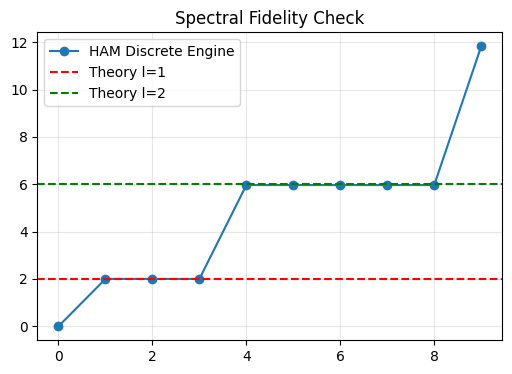

In [2]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
# Force CPU for stability on M3/Ryzen
os.environ['JAX_PLATFORMS'] = 'cpu'

def experiment_spectral_fidelity(subdivisions=3):
    print(f"--- Experiment 1: Spectral Geometry on S^2 (Res={subdivisions}) ---")
    
    # 1. Generate Mesh via HAM Utils
    verts, faces = generate_icosphere(subdivisions)
    verts = jnp.array(verts)
    faces = jnp.array(faces)
    print(f"Mesh: {len(verts)} vertices, {len(faces)} faces")
    
    # 2. Define Identity Metric (Riemannian Sphere)
    # We create a metric where L=I and beta=0 everywhere
    num_faces = len(faces)
    metric = RandersMetric(
        a=None, # Not needed for this calculation
        L=jnp.tile(jnp.eye(3), (num_faces, 1, 1)),
        beta=jnp.tile(jnp.zeros(3), (num_faces, 1))
    )
    
    # 3. Define Finsler-Laplace-Beltrami Operator (Inline for clarity)
    def compute_stiffness(face_idx, L, beta):
        p0, p1, p2 = verts[faces[face_idx][0]], verts[faces[face_idx][1]], verts[faces[face_idx][2]]
        
        # Approx Area
        v01 = jnp.dot(L.T, p1 - p0)
        v02 = jnp.dot(L.T, p2 - p0)
        area = 0.5 * jnp.linalg.norm(jnp.cross(v01, v02)) + 1e-12
        
        # Edge Lengths (Squared Randers Norm)
        def dist_sq(a, b):
            vec = b - a
            alpha = jnp.sqrt(jnp.dot(jnp.dot(L.T, vec), jnp.dot(L.T, vec)) + 1e-12)
            drift = jnp.dot(beta, vec)
            return (alpha + drift)**2
            
        l_12 = dist_sq(p1, p2); l_20 = dist_sq(p2, p0); l_01 = dist_sq(p0, p1)
        
        # Cotangents
        cot_0 = (l_01 + l_20 - l_12) / (8.0 * area)
        cot_1 = (l_12 + l_01 - l_20) / (8.0 * area)
        cot_2 = (l_20 + l_12 - l_01) / (8.0 * area)
        
        return jnp.array([[cot_1+cot_2, -cot_2, -cot_1], [-cot_2, cot_0+cot_2, -cot_0], [-cot_1, -cot_0, cot_0+cot_1]])

    # 4. Compute & Assemble
    stiffness_local = vmap(compute_stiffness)(jnp.arange(num_faces), metric.L, metric.beta)
    
    # Simple Lumped Mass (Area / 3)
    # For exact spectrum we usually need full Mass matrix, but this approximates well for low freq
    face_areas = vmap(lambda i: 0.5 * jnp.linalg.norm(jnp.cross(verts[faces[i][1]]-verts[faces[i][0]], verts[faces[i][2]]-verts[faces[i][0]])))(jnp.arange(num_faces))
    vertex_areas = np.zeros(len(verts))
    np.add.at(vertex_areas, faces[:,0], face_areas/3)
    np.add.at(vertex_areas, faces[:,1], face_areas/3)
    np.add.at(vertex_areas, faces[:,2], face_areas/3)

    # Assemble Sparse L
    I, J, V = [], [], []
    stiffness_np = np.array(stiffness_local)
    faces_np = np.array(faces)
    for f_idx in range(num_faces):
        for r in range(3):
            for c in range(3):
                I.append(faces_np[f_idx, r])
                J.append(faces_np[f_idx, c])
                V.append(stiffness_np[f_idx, r, c])
                
    L_mat = coo_matrix((V, (I, J)), shape=(len(verts), len(verts)))
    M_mat = coo_matrix((vertex_areas, (range(len(verts)), range(len(verts)))), shape=(len(verts), len(verts)))
    
    # 5. Solve
    vals, _ = eigsh(L_mat, k=10, M=M_mat, sigma=-0.01, which='LM')
    
    print("Computed Eigenvalues:", np.round(vals, 3))
    
    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(vals, 'o-', label='HAM Discrete Engine')
    plt.axhline(2.0, color='r', linestyle='--', label='Theory l=1')
    plt.axhline(6.0, color='g', linestyle='--', label='Theory l=2')
    plt.legend(); plt.grid(True, alpha=0.3); plt.title("Spectral Fidelity Check")
    plt.show()

experiment_spectral_fidelity()

### Experiment 2: Holonomic Control (The 90-Degree Bend)
**Objective:** Demonstrate **Differentiable Topology Change**. Can the network learn to warp space to force a geodesic to deviate from its natural path?

* **Task:** Connect the Equator at $x=1$ to the Equator at $y=1$.
* **Constraint:** The path *must* pass through the North Pole ($z=1$).
* **Mechanism:** The network must learn a specific wind field that makes the equatorial path "expensive" (Headwind) and the polar detour "cheap" (Tailwind).

--- Reproducing: Holonomic Control (Target: [0.0, 0.0, 1.0]) ---
Training started...
Epoch 000 | Waypoint Miss: 1.4132
Epoch 000 | Waypoint Miss: 1.4132
Epoch 050 | Waypoint Miss: 0.1117
Epoch 050 | Waypoint Miss: 0.1117
Epoch 100 | Waypoint Miss: 0.0509
Epoch 100 | Waypoint Miss: 0.0509
Epoch 150 | Waypoint Miss: 0.0309
Epoch 150 | Waypoint Miss: 0.0309
Epoch 200 | Waypoint Miss: 0.0126
Epoch 200 | Waypoint Miss: 0.0126
Epoch 250 | Waypoint Miss: 0.0102
Epoch 250 | Waypoint Miss: 0.0102
Epoch 300 | Waypoint Miss: 0.0065
Epoch 300 | Waypoint Miss: 0.0065
Epoch 350 | Waypoint Miss: 0.0037
Epoch 350 | Waypoint Miss: 0.0037
Epoch 400 | Waypoint Miss: 0.0048
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.0048
Generating Visualization...


--- Reproducing: Holonomic Control (Target: [0.0, 0.0, 1.0]) ---
Training started...
Epoch 000 | Waypoint Miss: 1.4132
Epoch 000 | Waypoint Miss: 1.4132
Epoch 050 | Waypoint Miss: 0.1117
Epoch 050 | Waypoint Miss: 0.1117
Epoch 100 | Waypoint Miss: 0.0509
Epoch 100 | Waypoint Miss: 0.0509
Epoch 150 | Waypoint Miss: 0.0309
Epoch 150 | Waypoint Miss: 0.0309
Epoch 200 | Waypoint Miss: 0.0126
Epoch 200 | Waypoint Miss: 0.0126
Epoch 250 | Waypoint Miss: 0.0102
Epoch 250 | Waypoint Miss: 0.0102
Epoch 300 | Waypoint Miss: 0.0065
Epoch 300 | Waypoint Miss: 0.0065
Epoch 350 | Waypoint Miss: 0.0037
Epoch 350 | Waypoint Miss: 0.0037
Epoch 400 | Waypoint Miss: 0.0048
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.0048
Generating Visualization...


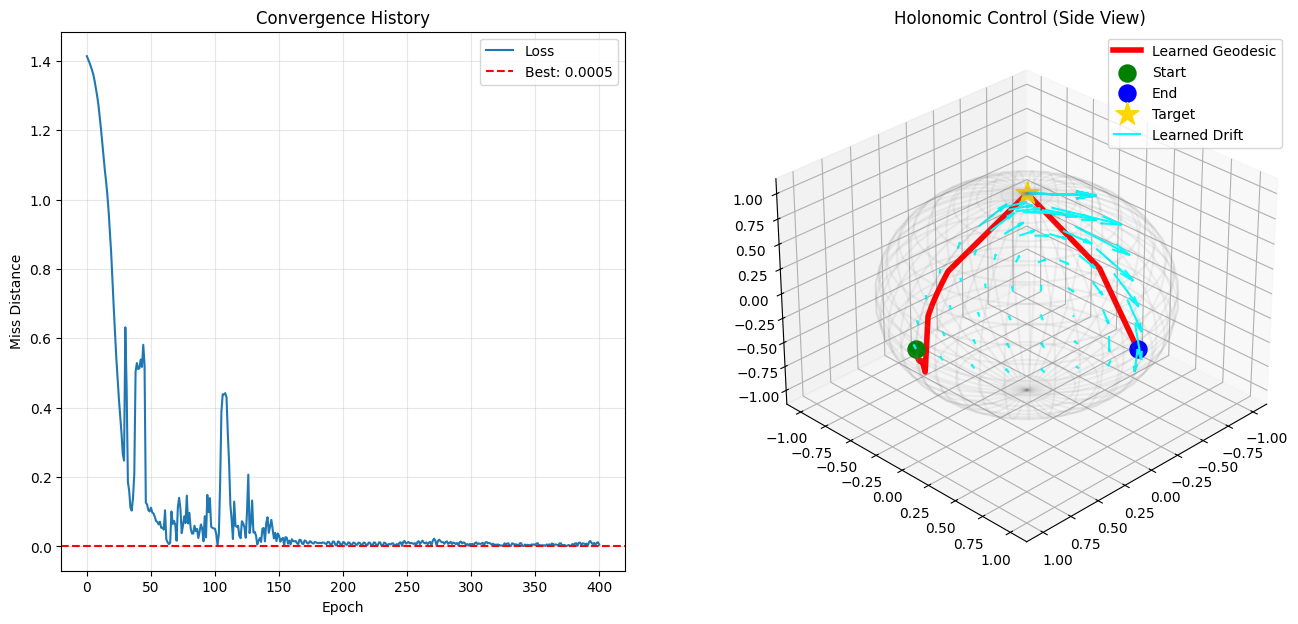

In [7]:
def experiment_holonomic_control(target_coords=[0.0, 0.0, 1.0]):
    print(f"--- Reproducing: Holonomic Control (Target: {target_coords}) ---")
    
    # 1. Setup
    manifold = Sphere(dim=2)
    
    # TUNING 1: Allow stronger winds (99% speed of light)
    factory = RandersFactory(manifold, epsilon=0.01) 
    
    key = jax.random.PRNGKey(42)
    net = MetricNet(key, input_dim=3, output_dim=3, hidden_dim=64)
    
    # Solver
    inner_solver = ProjectedGradientSolver(manifold, lr=0.005, max_iters=600)
    
    # Task Configuration
    start_p = jnp.array([1.0, 0.0, 0.0])
    end_p   = jnp.array([0.0, 1.0, 0.0])
    waypoint_p = jnp.array(target_coords) # Tweakable Target
    
    # Init Path
    steps = 20
    t = jnp.linspace(0, 1, steps)[1:-1]
    init_inner = start_p[None, :] * (1-t[:, None]) + end_p[None, :] * t[:, None]
    init_inner = vmap(manifold.projection)(init_inner)
    
    # Partition
    params, static = eqx.partition(net, eqx.is_array)
    
    # TUNING 2: Slower, Safer Learning Rate
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(0.005) 
    )
    opt_state = optimizer.init(params)
    
    @eqx.filter_jit 
    def train_step(params, static, opt_state):
        
        def loss_fn(p):
            model = eqx.combine(p, static)
            
            def metric_fn(x):
                raw_L, raw_W = model(x)
                return factory.forward(x, raw_L, raw_W)
            
            final_path = inner_solver.solve(
                lambda p: discrete_randers_energy(p, metric_fn),
                start_p, end_p, init_inner
            )
            
            dists = jnp.linalg.norm(final_path - waypoint_p[None, :], axis=1)
            min_dist = jnp.min(dists)
            
            # Minimal Reg
            reg = 1e-6 * sum(jnp.sum(w**2) for w in jax.tree_util.tree_leaves(p))
            
            return min_dist + reg, final_path

        (loss, path), grads = value_and_grad(loss_fn, has_aux=True)(params)
        
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        
        return new_params, opt_state, loss, path
    
    print("Training started...")
    
    best_params = params
    best_loss = 100.0
    history = []
    
    for epoch in range(401):
        new_params, opt_state, loss, final_path = train_step(params, static, opt_state)
        
        loss_val = float(loss)
        history.append(loss_val)
        
        if np.isnan(loss_val):
            print(f"WARNING: NaN detected at epoch {epoch}. Reverting to best.")
            params = best_params
            break
        
        params = new_params
        if loss_val < best_loss:
            best_loss = loss_val
            best_params = params
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d} | Waypoint Miss: {loss:.4f}")
    
    # Visualization
    final_net = eqx.combine(best_params, static)
    
    print("Generating Visualization...")
    fig = plt.figure(figsize=(16, 7)) # Wider figure for 2 plots
    
    # Plot 1: Convergence History
    ax1 = fig.add_subplot(121)
    ax1.plot(history, label='Loss')
    ax1.axhline(best_loss, color='r', linestyle='--', label=f'Best: {best_loss:.4f}')
    ax1.set_title("Convergence History")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Miss Distance")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: 3D Control
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Better Sphere Grid
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax2.plot_wireframe(x, y, z, color="gray", alpha=0.1)
    
    # Re-solve
    def metric_fn(x):
        raw_L, raw_W = final_net(x)
        return factory.forward(x, raw_L, raw_W)
        
    viz_path = inner_solver.solve(
        lambda p: discrete_randers_energy(p, metric_fn),
        start_p, end_p, init_inner
    )
    
    path_np = np.array(viz_path)
    ax2.plot(path_np[:,0], path_np[:,1], path_np[:,2], 'r-', linewidth=4, label='Learned Geodesic')
    
    ax2.scatter(1, 0, 0, c='g', s=150, label='Start')
    ax2.scatter(0, 1, 0, c='b', s=150, label='End')
    ax2.scatter(waypoint_p[0], waypoint_p[1], waypoint_p[2], c='gold', s=300, marker='*', label='Target')
    
    # Wind Field
    def get_wind(p):
        raw_L, raw_W = final_net(p)
        m = factory.forward(p, raw_L, raw_W)
        return -m.beta
    
    grid_pts = []
    # Show wind in the relevant octant
    for t in np.linspace(0, np.pi/2, 8):
        for p in np.linspace(0, np.pi/2, 8):
            grid_pts.append([np.cos(t)*np.sin(p), np.sin(t)*np.sin(p), np.cos(p)])
    grid_pts = jnp.array(grid_pts)
    
    winds = vmap(get_wind)(grid_pts)
    
    ax2.quiver(grid_pts[:,0], grid_pts[:,1], grid_pts[:,2],
              winds[:,0], winds[:,1], winds[:,2], length=0.2, color='cyan', label='Learned Drift')

    # Optimal Camera Angle
    ax2.view_init(elev=30, azim=45)
    ax2.set_title("Holonomic Control (Side View)")
    ax2.legend()
    
    plt.show()

# Example usage:
experiment_holonomic_control(target_coords=[0.0, 0.0, 1.0])

--- Reproducing: Holonomic Control (Target: [0.0, 0.0, -1.0]) ---
Training started...
Epoch 000 | Waypoint Miss: 1.4132
Epoch 000 | Waypoint Miss: 1.4132
Epoch 050 | Waypoint Miss: 0.5900
Epoch 050 | Waypoint Miss: 0.5900
Epoch 100 | Waypoint Miss: 0.0220
Epoch 100 | Waypoint Miss: 0.0220
Epoch 150 | Waypoint Miss: 0.0817
Epoch 150 | Waypoint Miss: 0.0817
Epoch 200 | Waypoint Miss: 0.0080
Epoch 200 | Waypoint Miss: 0.0080
Epoch 250 | Waypoint Miss: 0.0246
Epoch 250 | Waypoint Miss: 0.0246
Epoch 300 | Waypoint Miss: 0.0036
Epoch 300 | Waypoint Miss: 0.0036
Epoch 350 | Waypoint Miss: 0.0083
Epoch 350 | Waypoint Miss: 0.0083
Epoch 400 | Waypoint Miss: 0.0083
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.0083
Generating Visualization...


--- Reproducing: Holonomic Control (Target: [0.0, 0.0, -1.0]) ---
Training started...
Epoch 000 | Waypoint Miss: 1.4132
Epoch 000 | Waypoint Miss: 1.4132
Epoch 050 | Waypoint Miss: 0.5900
Epoch 050 | Waypoint Miss: 0.5900
Epoch 100 | Waypoint Miss: 0.0220
Epoch 100 | Waypoint Miss: 0.0220
Epoch 150 | Waypoint Miss: 0.0817
Epoch 150 | Waypoint Miss: 0.0817
Epoch 200 | Waypoint Miss: 0.0080
Epoch 200 | Waypoint Miss: 0.0080
Epoch 250 | Waypoint Miss: 0.0246
Epoch 250 | Waypoint Miss: 0.0246
Epoch 300 | Waypoint Miss: 0.0036
Epoch 300 | Waypoint Miss: 0.0036
Epoch 350 | Waypoint Miss: 0.0083
Epoch 350 | Waypoint Miss: 0.0083
Epoch 400 | Waypoint Miss: 0.0083
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.0083
Generating Visualization...


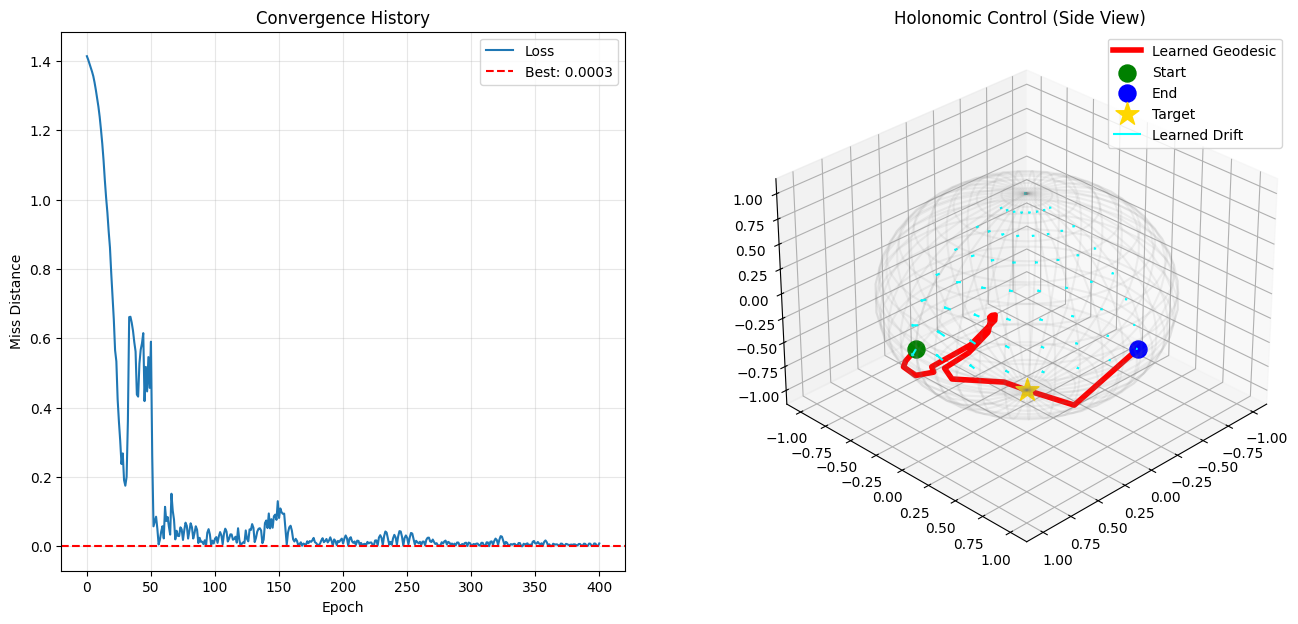

In [8]:
experiment_holonomic_control(target_coords=[0.0, 0.0, -1.0])

--- Reproducing: Holonomic Control (Target: [0.5, 0.5, 0.7]) ---
Training started...
Epoch 000 | Waypoint Miss: 0.7601
Epoch 000 | Waypoint Miss: 0.7601
Epoch 050 | Waypoint Miss: 0.0419
Epoch 050 | Waypoint Miss: 0.0419
Epoch 100 | Waypoint Miss: 0.0278
Epoch 100 | Waypoint Miss: 0.0278
Epoch 150 | Waypoint Miss: 0.0071
Epoch 150 | Waypoint Miss: 0.0071
Epoch 200 | Waypoint Miss: 0.0051
Epoch 200 | Waypoint Miss: 0.0051
Epoch 250 | Waypoint Miss: 0.0051
Epoch 250 | Waypoint Miss: 0.0051
Epoch 300 | Waypoint Miss: 0.0051
Epoch 300 | Waypoint Miss: 0.0051
Epoch 350 | Waypoint Miss: 0.0051
Epoch 350 | Waypoint Miss: 0.0051
Epoch 400 | Waypoint Miss: 0.0052
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.0052
Generating Visualization...


--- Reproducing: Holonomic Control (Target: [0.5, 0.5, 0.7]) ---
Training started...
Epoch 000 | Waypoint Miss: 0.7601
Epoch 000 | Waypoint Miss: 0.7601
Epoch 050 | Waypoint Miss: 0.0419
Epoch 050 | Waypoint Miss: 0.0419
Epoch 100 | Waypoint Miss: 0.0278
Epoch 100 | Waypoint Miss: 0.0278
Epoch 150 | Waypoint Miss: 0.0071
Epoch 150 | Waypoint Miss: 0.0071
Epoch 200 | Waypoint Miss: 0.0051
Epoch 200 | Waypoint Miss: 0.0051
Epoch 250 | Waypoint Miss: 0.0051
Epoch 250 | Waypoint Miss: 0.0051
Epoch 300 | Waypoint Miss: 0.0051
Epoch 300 | Waypoint Miss: 0.0051
Epoch 350 | Waypoint Miss: 0.0051
Epoch 350 | Waypoint Miss: 0.0051
Epoch 400 | Waypoint Miss: 0.0052
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.0052
Generating Visualization...


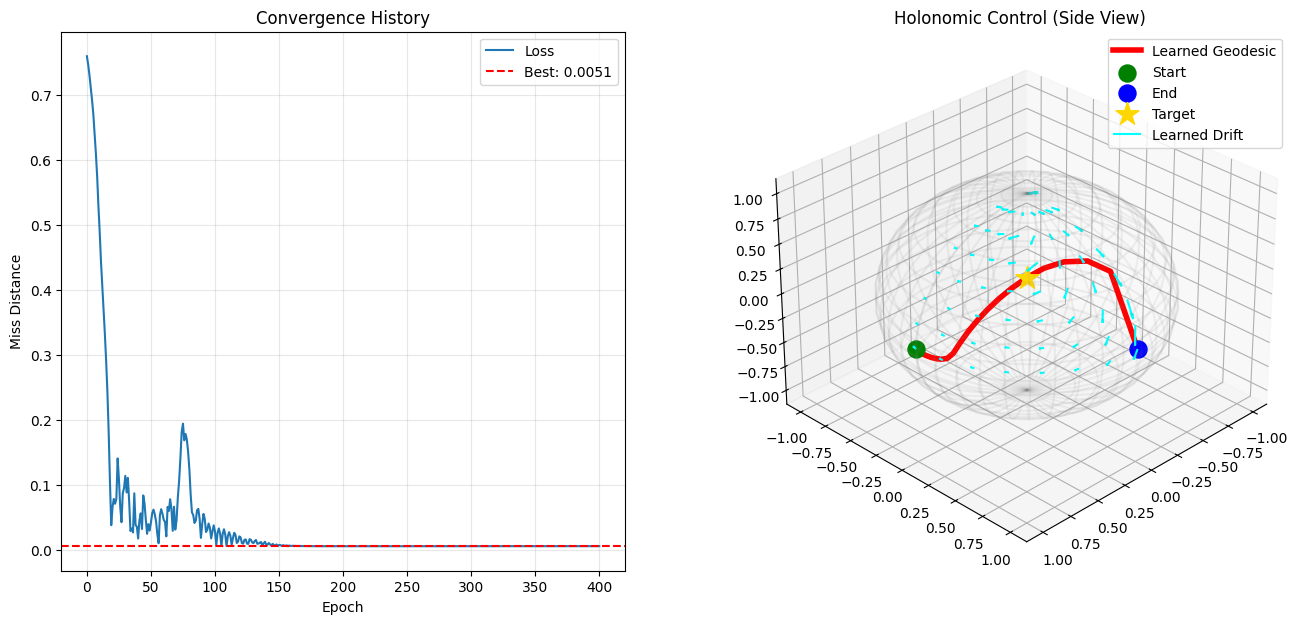

In [9]:
experiment_holonomic_control(target_coords=[0.5, 0.5, 0.7])

--- Reproducing: Holonomic Control (Target: [0.8, 0.2, 0.8]) ---
Training started...
Epoch 000 | Waypoint Miss: 0.8209
Epoch 000 | Waypoint Miss: 0.8209
Epoch 050 | Waypoint Miss: 0.1497
Epoch 050 | Waypoint Miss: 0.1497
Epoch 100 | Waypoint Miss: 0.1490
Epoch 100 | Waypoint Miss: 0.1490
Epoch 150 | Waypoint Miss: 0.1490
Epoch 150 | Waypoint Miss: 0.1490
Epoch 200 | Waypoint Miss: 0.1490
Epoch 200 | Waypoint Miss: 0.1490
Epoch 250 | Waypoint Miss: 0.1490
Epoch 250 | Waypoint Miss: 0.1490
Epoch 300 | Waypoint Miss: 0.1490
Epoch 300 | Waypoint Miss: 0.1490
Epoch 350 | Waypoint Miss: 0.1490
Epoch 350 | Waypoint Miss: 0.1490
Epoch 400 | Waypoint Miss: 0.1490
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.1490
Generating Visualization...


--- Reproducing: Holonomic Control (Target: [0.8, 0.2, 0.8]) ---
Training started...
Epoch 000 | Waypoint Miss: 0.8209
Epoch 000 | Waypoint Miss: 0.8209
Epoch 050 | Waypoint Miss: 0.1497
Epoch 050 | Waypoint Miss: 0.1497
Epoch 100 | Waypoint Miss: 0.1490
Epoch 100 | Waypoint Miss: 0.1490
Epoch 150 | Waypoint Miss: 0.1490
Epoch 150 | Waypoint Miss: 0.1490
Epoch 200 | Waypoint Miss: 0.1490
Epoch 200 | Waypoint Miss: 0.1490
Epoch 250 | Waypoint Miss: 0.1490
Epoch 250 | Waypoint Miss: 0.1490
Epoch 300 | Waypoint Miss: 0.1490
Epoch 300 | Waypoint Miss: 0.1490
Epoch 350 | Waypoint Miss: 0.1490
Epoch 350 | Waypoint Miss: 0.1490
Epoch 400 | Waypoint Miss: 0.1490
Generating Visualization...
Epoch 400 | Waypoint Miss: 0.1490
Generating Visualization...


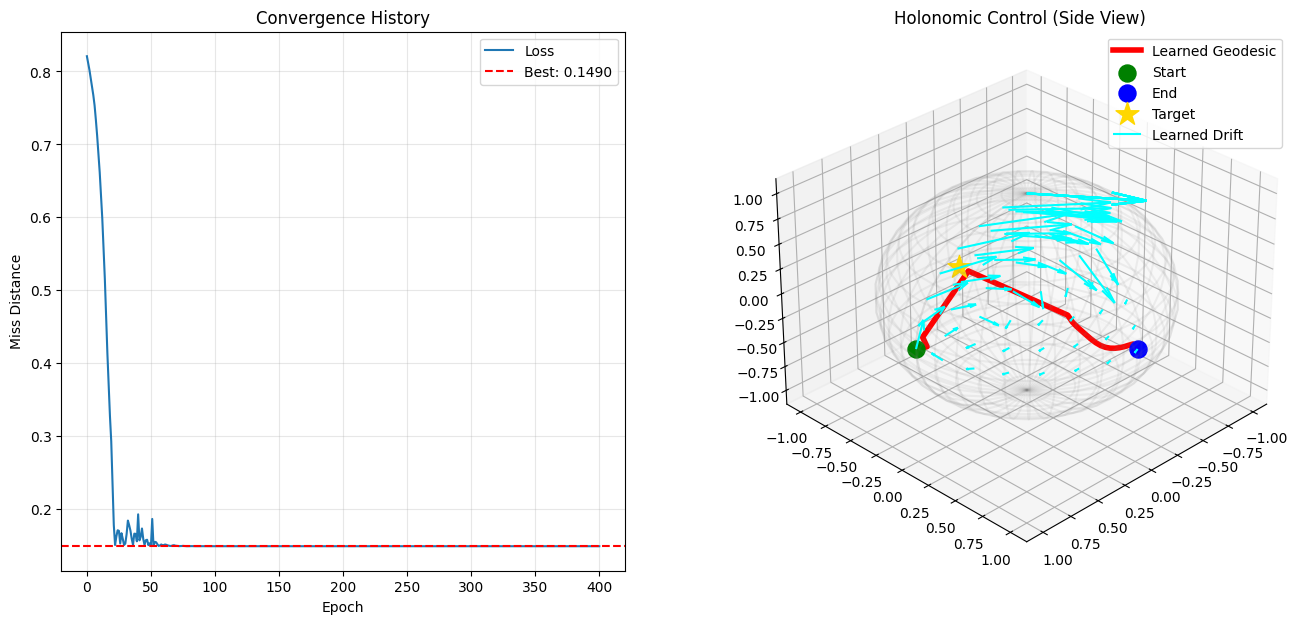

In [10]:
experiment_holonomic_control(target_coords=[0.8, 0.2, 0.8])

--- Experiment: Strict Wind-Only Network (Target: [0.5, 0.5, 0.7]) ---
Training...
Epoch 0: 0.7607
Epoch 0: 0.7607
Epoch 100: 0.6588
Epoch 100: 0.6588
Epoch 200: 0.6461
Epoch 200: 0.6461
Epoch 300: 0.6416
Epoch 300: 0.6416
Epoch 400: 0.6378
Epoch 400: 0.6378


--- Experiment: Strict Wind-Only Network (Target: [0.5, 0.5, 0.7]) ---
Training...
Epoch 0: 0.7607
Epoch 0: 0.7607
Epoch 100: 0.6588
Epoch 100: 0.6588
Epoch 200: 0.6461
Epoch 200: 0.6461
Epoch 300: 0.6416
Epoch 300: 0.6416
Epoch 400: 0.6378
Epoch 400: 0.6378


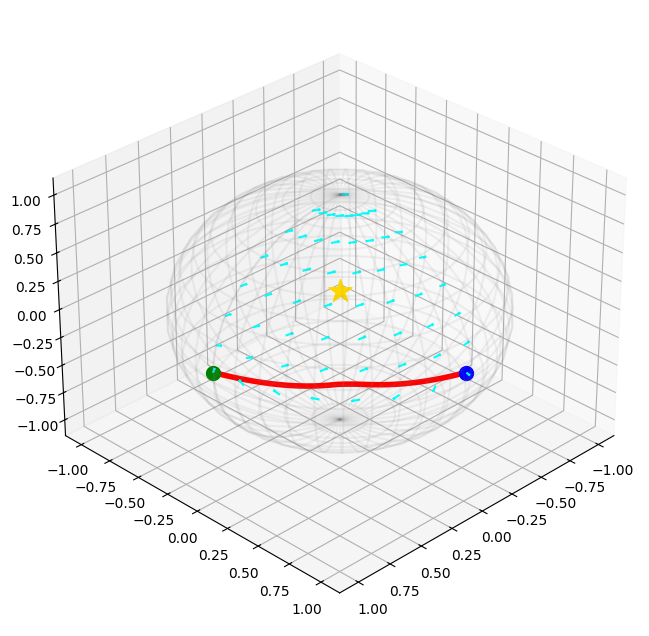

In [17]:
def experiment_strict_wind_only(target_coords):
    print(f"--- Experiment: Strict Wind-Only Network (Target: {target_coords}) ---")
    
    manifold = Sphere(dim=2)
    factory = RandersFactory(manifold, epsilon=0.01)
    
    # 1. Use WindNet (Only outputs W)
    key = jax.random.PRNGKey(42)
    # Note: You need to add WindNet to your imports or define it inline
    net = WindNet(key, input_dim=3, hidden_dim=64)
    
    inner_solver = ProjectedGradientSolver(manifold, lr=0.005, max_iters=800)
    
    start = jnp.array([1.0, 0.0, 0.0])
    end = jnp.array([0.0, 1.0, 0.0])
    waypoint_p = jnp.array(target_coords)
    
    t = jnp.linspace(0, 1, 40)[1:-1]
    init_path = vmap(manifold.projection)(start[None,:]*(1-t[:,None]) + end[None,:]*t[:,None])
    
    params, static = eqx.partition(net, eqx.is_array)
    optimizer = optax.chain(optax.clip_by_global_norm(10.0), optax.adam(0.02))
    opt_state = optimizer.init(params)
    
    @eqx.filter_jit 
    def step(params, static, opt_state):
        def loss_fn(p):
            model = eqx.combine(p, static)
            
            def metric_fn(x):
                # Model only returns raw_W
                raw_W = model(x)
                
                # FIX L to Identity (Standard Sphere)
                # or Scaled Identity (Base speed)
                # Using 4.0 to match previous scaling
                fixed_L = jnp.ones(3) * 4.0 
                
                return factory.forward(x, fixed_L, raw_W)
            
            path = inner_solver.solve(lambda p: discrete_randers_energy(p, metric_fn), start, end, init_path)
            dist = jnp.min(jnp.linalg.norm(path - waypoint_p[None, :], axis=1))
            reg = 1e-6 * sum(jnp.sum(w**2) for w in jax.tree_util.tree_leaves(p))
            return dist + reg, path
            
        (loss, path), grads = value_and_grad(loss_fn, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        return optax.apply_updates(params, updates), opt_state, loss, path

    print("Training...")
    for i in range(401):
        params, opt_state, loss, final_path = step(params, static, opt_state)
        if i % 100 == 0: print(f"Epoch {i}: {loss:.4f}")
            
    # Visualization
    final_net = eqx.combine(params, static)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v); y = np.sin(u)*np.sin(v); z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)
    
    path = np.array(final_path)
    full = np.concatenate([start[None,:], path, end[None,:]])
    ax.plot(full[:,0], full[:,1], full[:,2], 'r-', linewidth=4, label='Wind-Only Path')
    
    # Visualize W
    grid = np.array([[np.cos(t)*np.sin(p), np.sin(t)*np.sin(p), np.cos(p)] 
                     for t in np.linspace(0, np.pi/2, 8) for p in np.linspace(0, np.pi/2, 8)])
    
    def get_wind(p):
        # Reconstruct metric to get beta, then negate
        fixed_L = jnp.ones(3) * 4.0
        m = factory.forward(p, fixed_L, final_net(p))
        return -m.beta
        
    winds = vmap(get_wind)(jnp.array(grid))
    ax.quiver(grid[:,0], grid[:,1], grid[:,2], winds[:,0], winds[:,1], winds[:,2], length=0.2, color='cyan')
    
    ax.scatter(*waypoint_p, c='gold', s=300, marker='*')
    ax.scatter(*start, c='g', s=100); ax.scatter(*end, c='b', s=100)
    ax.view_init(30, 45)
    plt.show()

# Define WindNet class inline for the notebook if not in file
class WindNet(eqx.Module):
    layers: list
    def __init__(self, key, input_dim=3, hidden_dim=64):
        k1, k2, k3 = jax.random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(input_dim, hidden_dim, key=k1),
            eqx.nn.Lambda(jax.nn.tanh),
            eqx.nn.Linear(hidden_dim, hidden_dim, key=k2),
            eqx.nn.Lambda(jax.nn.tanh),
            eqx.nn.Linear(hidden_dim, input_dim, key=k3)
        ]
    def __call__(self, x):
        for layer in self.layers: x = layer(x)
        return x

# Run Hard Case
experiment_strict_wind_only(target_coords=[0.5, 0.5, 0.7])

--- Experiment: Strict Wind-Only Network (Target: [0.5, 0.5, 0.7]) ---
Solver: AVBDSolver (Augmented Lagrangian)
Training...
Epoch 0: 0.7618 (Best: 0.7618)
Epoch 0: 0.7618 (Best: 0.7618)
Epoch 50: 0.6595 (Best: 0.6447)
Epoch 50: 0.6595 (Best: 0.6447)
Epoch 100: 0.6104 (Best: 0.6104)
Epoch 100: 0.6104 (Best: 0.6104)
Epoch 150: 0.6193 (Best: 0.6059)
Epoch 150: 0.6193 (Best: 0.6059)
Epoch 200: 0.6485 (Best: 0.6059)
Epoch 200: 0.6485 (Best: 0.6059)
Epoch 250: 0.6333 (Best: 0.6059)
Epoch 250: 0.6333 (Best: 0.6059)
Epoch 300: 0.6207 (Best: 0.6059)
Epoch 300: 0.6207 (Best: 0.6059)
Epoch 350: 0.6125 (Best: 0.6059)
Epoch 350: 0.6125 (Best: 0.6059)
Epoch 400: 0.6029 (Best: 0.6029)
Epoch 400: 0.6029 (Best: 0.6029)


--- Experiment: Strict Wind-Only Network (Target: [0.5, 0.5, 0.7]) ---
Solver: AVBDSolver (Augmented Lagrangian)
Training...
Epoch 0: 0.7618 (Best: 0.7618)
Epoch 0: 0.7618 (Best: 0.7618)
Epoch 50: 0.6595 (Best: 0.6447)
Epoch 50: 0.6595 (Best: 0.6447)
Epoch 100: 0.6104 (Best: 0.6104)
Epoch 100: 0.6104 (Best: 0.6104)
Epoch 150: 0.6193 (Best: 0.6059)
Epoch 150: 0.6193 (Best: 0.6059)
Epoch 200: 0.6485 (Best: 0.6059)
Epoch 200: 0.6485 (Best: 0.6059)
Epoch 250: 0.6333 (Best: 0.6059)
Epoch 250: 0.6333 (Best: 0.6059)
Epoch 300: 0.6207 (Best: 0.6059)
Epoch 300: 0.6207 (Best: 0.6059)
Epoch 350: 0.6125 (Best: 0.6059)
Epoch 350: 0.6125 (Best: 0.6059)
Epoch 400: 0.6029 (Best: 0.6029)
Epoch 400: 0.6029 (Best: 0.6029)


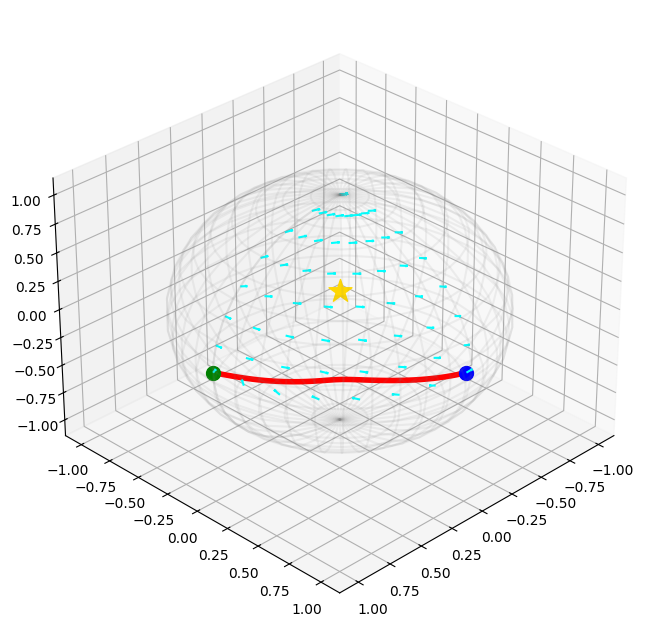

In [22]:
from ham.solvers import AVBDSolver

def experiment_strict_wind_only(target_coords):
    print(f"--- Experiment: Strict Wind-Only Network (Target: {target_coords}) ---")
    print("Solver: AVBDSolver (Augmented Lagrangian)")
    
    manifold = Sphere(dim=2)
    factory = RandersFactory(manifold, epsilon=0.01)
    
    # 1. Define WindNet (Inline for notebook portability)
    class WindNet(eqx.Module):
        layers: list
        def __init__(self, key, input_dim=3, hidden_dim=64):
            k1, k2, k3 = jax.random.split(key, 3)
            self.layers = [
                eqx.nn.Linear(input_dim, hidden_dim, key=k1),
                eqx.nn.Lambda(jax.nn.tanh),
                eqx.nn.Linear(hidden_dim, hidden_dim, key=k2),
                eqx.nn.Lambda(jax.nn.tanh),
                eqx.nn.Linear(hidden_dim, input_dim, key=k3)
            ]
        def __call__(self, x):
            for layer in self.layers: x = layer(x)
            return x

    key = jax.random.PRNGKey(42)
    net = WindNet(key, input_dim=3, hidden_dim=64)
    
    # 2. Setup AVBD Solver
    # Needs explicit constraint function C(x) = 0
    def sphere_constraint(x):
        return jnp.linalg.norm(x) - 1.0

    # Use aggressive hardening (beta=2.0) to force constraint compliance quickly
    inner_solver = AVBDSolver(lr=0.01, beta=2.0, max_iters=800)
    
    # Task
    start = jnp.array([1.0, 0.0, 0.0])
    end = jnp.array([0.0, 1.0, 0.0])
    waypoint_p = jnp.array(target_coords)
    
    # Init Path
    t = jnp.linspace(0, 1, 40)[1:-1]
    init_path = start[None,:]*(1-t[:,None]) + end[None,:]*t[:,None]
    # For AVBD, we don't strictly need projected init, but it helps convergence
    init_path = vmap(manifold.projection)(init_path)
    
    # 3. Training
    params, static = eqx.partition(net, eqx.is_array)
    # Aggressive optimizer for the network
    optimizer = optax.chain(optax.clip_by_global_norm(10.0), optax.adam(0.02))
    opt_state = optimizer.init(params)
    
    @eqx.filter_jit 
    def step(params, static, opt_state):
        def loss_fn(p):
            model = eqx.combine(p, static)
            
            def metric_fn(x):
                # 1. Get Learned Wind
                raw_W = model(x)
                # 2. Fix Metric L to Constant Scaled Identity (Base speed)
                fixed_L = jnp.ones(3) * 4.0 
                return factory.forward(x, fixed_L, raw_W)
            
            # Solve with AVBD
            path = inner_solver.solve(
                lambda p: discrete_randers_energy(p, metric_fn),
                [sphere_constraint], # Constraint List
                start, end, init_path
            )
            
            dist = jnp.min(jnp.linalg.norm(path - waypoint_p[None, :], axis=1))
            reg = 1e-6 * sum(jnp.sum(w**2) for w in jax.tree_util.tree_leaves(p))
            return dist + reg, path
            
        (loss, path), grads = value_and_grad(loss_fn, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        return optax.apply_updates(params, updates), opt_state, loss, path

    print("Training...")
    best_loss = 100.0
    best_path = init_path
    best_params = params

    for i in range(401):
        params, opt_state, loss, path = step(params, static, opt_state)
        loss_val = float(loss)
        
        if np.isnan(loss_val):
            print(f"NaN at epoch {i}. Reverting to best.")
            params = best_params
            break
            
        if loss_val < best_loss:
            best_loss = loss_val
            best_path = path
            best_params = params
            
        if i % 50 == 0: print(f"Epoch {i}: {loss_val:.4f} (Best: {best_loss:.4f})")
            
    # 4. Visualization
    final_net = eqx.combine(best_params, static)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v); y = np.sin(u)*np.sin(v); z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)
    
    path = np.array(best_path)
    full = np.concatenate([start[None,:], path, end[None,:]])
    ax.plot(full[:,0], full[:,1], full[:,2], 'r-', linewidth=4, label='Wind-Only AVBD Path')
    
    # Visualize W (-beta)
    grid = np.array([[np.cos(t)*np.sin(p), np.sin(t)*np.sin(p), np.cos(p)] 
                     for t in np.linspace(0, np.pi/2, 8) for p in np.linspace(0, np.pi/2, 8)])
    
    def get_wind(p):
        fixed_L = jnp.ones(3) * 4.0
        m = factory.forward(p, fixed_L, final_net(p))
        return -m.beta
        
    winds = vmap(get_wind)(jnp.array(grid))
    ax.quiver(grid[:,0], grid[:,1], grid[:,2], winds[:,0], winds[:,1], winds[:,2], length=0.2, color='cyan')
    
    ax.scatter(*waypoint_p, c='gold', s=300, marker='*')
    ax.scatter(*start, c='g', s=100); ax.scatter(*end, c='b', s=100)
    ax.view_init(30, 45)
    plt.show()

# Run Hard Case
experiment_strict_wind_only(target_coords=[0.5, 0.5, 0.7])

### Experiment 3: The Cost of Control (Finsler vs. Riemannian)
**Objective:** Visualize *how* the model achieves control.

We use **Tissot's Indicatrix** to visualize the unit cost ball at various points.
* **Riemannian Control ($\beta=0$):** Achieves control by crushing space into thin ellipses (high distortion).
* **Finsler Control ($\beta \neq 0$):** Achieves control by shifting the center of the ball (wind), preserving the local shape of the space.

--- Experiment 3: The Cost of Control (Slalom) ---
Training Finsler Model...
Epoch 0: 0.6155
Epoch 0: 0.6155
Epoch 50: 0.0098
Epoch 50: 0.0098
Epoch 100: 0.0207
Epoch 100: 0.0207
Epoch 150: 0.0258
Epoch 150: 0.0258
Epoch 200: 0.0251
Training Riemannian Model...
Epoch 200: 0.0251
Training Riemannian Model...
Epoch 0: 0.5973
Epoch 0: 0.5973
Epoch 50: 0.0232
Epoch 50: 0.0232
Epoch 100: 0.0166
Epoch 100: 0.0166
Epoch 150: 0.0152
Epoch 150: 0.0152
Epoch 200: 0.0124
Epoch 200: 0.0124


--- Experiment 3: The Cost of Control (Slalom) ---
Training Finsler Model...
Epoch 0: 0.6155
Epoch 0: 0.6155
Epoch 50: 0.0098
Epoch 50: 0.0098
Epoch 100: 0.0207
Epoch 100: 0.0207
Epoch 150: 0.0258
Epoch 150: 0.0258
Epoch 200: 0.0251
Training Riemannian Model...
Epoch 200: 0.0251
Training Riemannian Model...
Epoch 0: 0.5973
Epoch 0: 0.5973
Epoch 50: 0.0232
Epoch 50: 0.0232
Epoch 100: 0.0166
Epoch 100: 0.0166
Epoch 150: 0.0152
Epoch 150: 0.0152
Epoch 200: 0.0124
Epoch 200: 0.0124


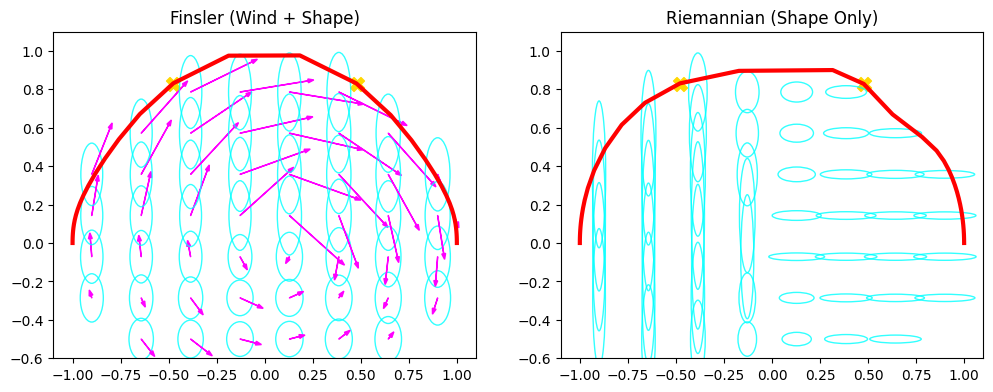

In [28]:
from matplotlib.patches import Ellipse

def experiment_slalom_comparison():
    print("--- Experiment 3: The Cost of Control (Slalom) ---")
    
    manifold = Sphere(dim=2)
    
    # Task: Start -> End (Antipodal)
    start = jnp.array([1.0, 0.0, 0.0])
    end = jnp.array([-1.0, 0.0, 0.0])
    
    # Gates
    g1 = jnp.array([0.5, 0.866, 0.3]); g1 /= jnp.linalg.norm(g1)
    g2 = jnp.array([-0.5, 0.866, -0.3]); g2 /= jnp.linalg.norm(g2)
    
    # CRITICAL FIX: Safe Initialization for Antipodal Points
    # We add a small perturbation (y-axis arch) to avoid the origin [0,0,0]
    t = jnp.linspace(0, 1, 40)[1:-1]
    linear_interp = start[None,:]*(1-t[:,None]) + end[None,:]*t[:,None]
    # Add offset to avoid 0/0 division at midpoint
    offset = jnp.array([0.0, 0.1, 0.0]) * jnp.sin(t[:,None] * jnp.pi)
    init_path = vmap(manifold.projection)(linear_interp + offset)
    
    def train_slalom_model(mode="finsler"):
        print(f"Training {mode.title()} Model...")
        
        # Allow 99% wind for Finsler, mask it for Riemannian
        factory = RandersFactory(manifold, epsilon=0.01)
        
        key = jax.random.PRNGKey(42)
        net = MetricNet(key, input_dim=3, output_dim=3, hidden_dim=64)
        
        # Solver
        solver = ProjectedGradientSolver(manifold, lr=0.01, max_iters=400)
        
        params, static = eqx.partition(net, eqx.is_array)
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.adam(0.005)
        )
        opt_state = optimizer.init(params)
        
        @eqx.filter_jit
        def step(params, static, opt_state):
            def loss_fn(p):
                model = eqx.combine(p, static)
                def metric_fn(x):
                    raw_L, raw_W = model(x)
                    if mode == "riemannian":
                        raw_W = jnp.zeros_like(raw_W) # Force Wind=0
                    return factory.forward(x, raw_L, raw_W)
                
                path = solver.solve(lambda p: discrete_randers_energy(p, metric_fn), start, end, init_path)
                
                d1 = jnp.min(jnp.linalg.norm(path - g1[None,:], axis=1))
                d2 = jnp.min(jnp.linalg.norm(path - g2[None,:], axis=1))
                
                reg = 1e-5 * sum(jnp.sum(w**2) for w in jax.tree_util.tree_leaves(p))
                return d1 + d2 + reg, path
                
            (loss, path), grads = value_and_grad(loss_fn, has_aux=True)(params)
            updates, opt_state = optimizer.update(grads, opt_state)
            return optax.apply_updates(params, updates), opt_state, loss, path

        for i in range(201):
            params, opt_state, loss, path = step(params, static, opt_state)
            if np.isnan(loss):
                print("NaN detected (ignoring for visual, using last good params)")
                break
            if i % 50 == 0: print(f"Epoch {i}: {loss:.4f}")
            
        return eqx.combine(params, static)

    model_finsler = train_slalom_model("finsler")
    model_riemann = train_slalom_model("riemannian")
    
    # 3. Visualization
    def plot_tissot(ax, model, title, mode):
        ax.set_title(title)
        grid = np.array([[x, y, 0] for x in np.linspace(-0.9, 0.9, 8) for y in np.linspace(-0.5, 1.0, 8)])
        
        # Re-solve path
        factory = RandersFactory(manifold, epsilon=0.01)
        solver = ProjectedGradientSolver(manifold, lr=0.01, max_iters=400)
        
        def metric_fn(x):
            raw_L, raw_W = model(x)
            if mode == "riemannian": raw_W = jnp.zeros_like(raw_W)
            return factory.forward(x, raw_L, raw_W)
            
        path = solver.solve(lambda p: discrete_randers_energy(p, metric_fn), start, end, init_path)
        path = np.array(path)
        ax.plot(path[:,0], path[:,1], 'r-', linewidth=3)
        
        ax.scatter(g1[0], g1[1], c='gold', marker='X', s=100)
        ax.scatter(g2[0], g2[1], c='gold', marker='X', s=100)
        
        for p in grid:
            p_sphere = p / np.linalg.norm(p)
            if p[0]**2 + p[1]**2 > 0.95: continue 
            
            m = metric_fn(jnp.array(p_sphere))
            
            # Shape
            g_3d = m.L @ m.L.T
            g_2d = g_3d[:2, :2] 
            evals, evecs = jnp.linalg.eigh(g_2d)
            scale = 0.12
            width = scale / jnp.sqrt(evals[0] + 1e-6)
            height = scale / jnp.sqrt(evals[1] + 1e-6)
            angle = np.degrees(np.arctan2(evecs[1,0], evecs[0,0]))
            
            # Shift (-beta)
            shift = -m.beta[:2] * 0.5 if mode == "finsler" else np.zeros(2)
            
            ell = Ellipse(xy=(p[0], p[1]), width=width, height=height, angle=angle, 
                          edgecolor='cyan', facecolor='none', alpha=0.8)
            ax.add_patch(ell)
            
            if jnp.linalg.norm(shift) > 0.01:
                ax.arrow(p[0], p[1], shift[0], shift[1], head_width=0.02, color='magenta')

        ax.set_xlim(-1.1, 1.1); ax.set_ylim(-0.6, 1.1)
        ax.set_aspect('equal')

    fig = plt.figure(figsize=(12, 6))
    plot_tissot(fig.add_subplot(121), model_finsler, "Finsler (Wind + Shape)", "finsler")
    plot_tissot(fig.add_subplot(122), model_riemann, "Riemannian (Shape Only)", "riemannian")
    plt.show()

experiment_slalom_comparison()

### Experiment 4: Semantic Integration
**Objective:** Bridge Geometry and NLP.

We initialize a **Fibonacci Lattice** to distribute discrete tokens evenly on the sphere. We then demonstrate how a **Context-Conditioned Metric Network** can learn different vector fields ("Semantic Winds") for different context words (e.g., "Hierarchy" vs. "Cycle").

--- Experiment 4: Semantic Vector Fields ---
Training Semantic Model...
Epoch 0: Avg Energy 0.0128
Epoch 50: Avg Energy 0.0007
Epoch 100: Avg Energy 0.0005
Epoch 150: Avg Energy 0.0004
Epoch 200: Avg Energy 0.0003
Epoch 250: Avg Energy 0.0003
Epoch 300: Avg Energy 0.0002
Visualizing Contextual Geometries...


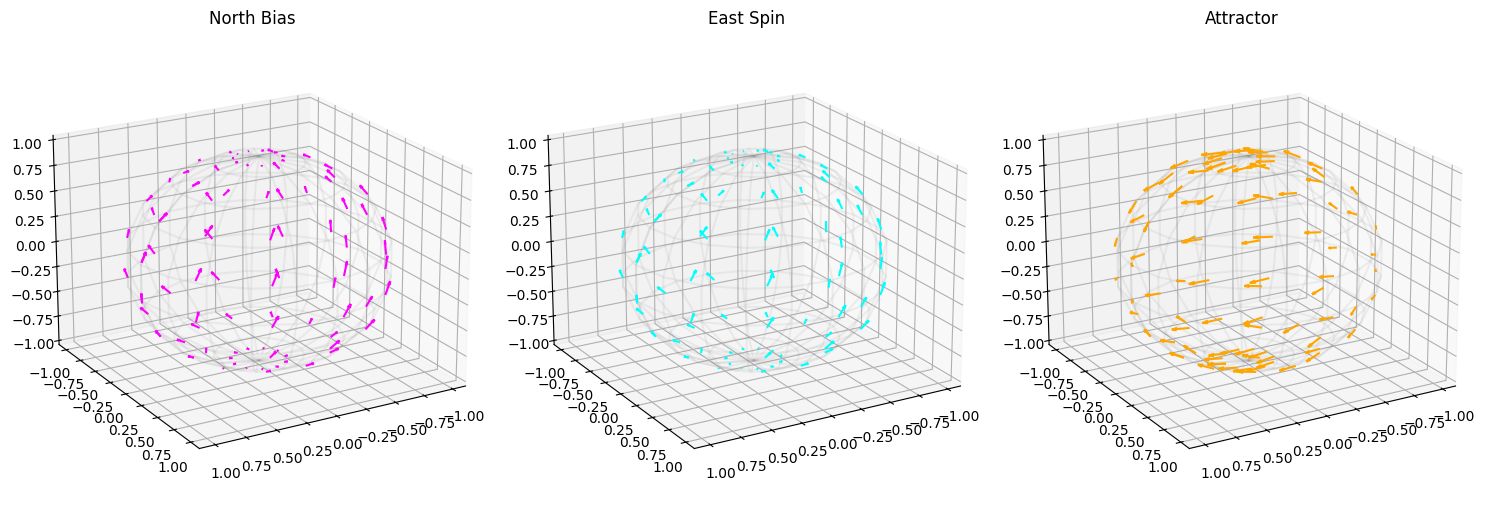

In [5]:
from ham.nn import ContextNet
from ham.embeddings import TokenMap

def experiment_semantics():
    print("--- Experiment 4: Semantic Vector Fields ---")
    
    # 1. Setup The Stage
    manifold = Sphere(dim=2)
    factory = RandersFactory(manifold, epsilon=0.01)
    
    vocab_size = 200
    token_map = TokenMap.create(vocab_size)
    
    # 2. Data Generator
    def generate_batch(key, batch_size=32):
        k1, k2 = jax.random.split(key)
        src_ids = jax.random.randint(k1, (batch_size,), 0, vocab_size)
        ctx_ids = jax.random.randint(k2, (batch_size,), 0, 3)
        
        src_coords = token_map.get_coords(src_ids)
        tgt_coords = np.array(src_coords)
        
        for i in range(batch_size):
            p = src_coords[i]
            c = ctx_ids[i]
            if c == 0: tgt = p + np.array([0.0, 0.0, 0.5]) # North
            elif c == 1: # Spin
                theta = 0.5
                new_x = p[0]*np.cos(theta) - p[1]*np.sin(theta)
                new_y = p[0]*np.sin(theta) + p[1]*np.cos(theta)
                tgt = np.array([new_x, new_y, p[2]])
            elif c == 2: # Attract
                attractor = np.array([1.0, 0.0, 0.0])
                tgt = p * 0.6 + attractor * 0.4
            
            tgt_coords[i] = tgt / np.linalg.norm(tgt)
            
        return src_coords, jnp.array(ctx_ids), jnp.array(tgt_coords)

    # 3. Initialize
    key = jax.random.PRNGKey(99)
    net = ContextNet(key, vocab_size=3, context_dim=8, manifold_dim=3, hidden_dim=64)
    inner_solver = ProjectedGradientSolver(manifold, lr=0.02, max_iters=50)
    
    params, static = eqx.partition(net, eqx.is_array)
    optimizer = optax.chain(
        optax.clip_by_global_norm(10.0),
        optax.adam(0.01)
    )
    opt_state = optimizer.init(params)
    
    # 4. Training Step
    @eqx.filter_jit
    def train_step(params, static, opt_state, src, ctx, tgt):
        def loss_fn(p):
            model = eqx.combine(p, static)
            
            def batch_loss(s, c, t):
                def metric_fn(x):
                    raw_L, raw_W = model(x, c)
                    return factory.forward(x, raw_L, raw_W)
                
                # Fast solver for training loop
                init_path = jnp.linspace(s, t, 10)[1:-1]
                path = inner_solver.solve(lambda p: discrete_randers_energy(p, metric_fn), s, t, init_path)
                return discrete_randers_energy(path, metric_fn)

            losses = vmap(batch_loss)(src, ctx, tgt)
            reg = 1e-5 * sum(jnp.sum(w**2) for w in jax.tree_util.tree_leaves(p))
            
            return jnp.mean(losses) + reg, None 

        (loss, _), grads = value_and_grad(loss_fn, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        return optax.apply_updates(params, updates), opt_state, loss

    print("Training Semantic Model...")
    history = []
    for i in range(301):
        key, subkey = jax.random.split(key)
        src, ctx, tgt = generate_batch(subkey, batch_size=32)
        
        params, opt_state, loss = train_step(params, static, opt_state, src, ctx, tgt)
        history.append(float(loss))
        
        if i % 50 == 0: print(f"Epoch {i}: Avg Energy {loss:.4f}")

    # 5. Visualization
    print("Visualizing Contextual Geometries...")
    final_net = eqx.combine(params, static)
    
    fig = plt.figure(figsize=(15, 5))
    grid_pts = []
    # Create grid for visualization
    for t in np.linspace(0, 2*np.pi, 12):
        for p in np.linspace(0.2, np.pi-0.2, 8):
            grid_pts.append([np.cos(t)*np.sin(p), np.sin(t)*np.sin(p), np.cos(p)])
    grid_pts = jnp.array(grid_pts)
    
    titles = ["North Bias", "East Spin", "Attractor"]
    colors = ['magenta', 'cyan', 'orange']
    
    for c_id in range(3):
        ax = fig.add_subplot(1, 3, c_id+1, projection='3d')
        ax.set_title(titles[c_id])
        
        def get_wind(p):
            raw_L, raw_W = final_net(p, c_id)
            m = factory.forward(p, raw_L, raw_W)
            return -m.beta 
            
        winds = vmap(get_wind)(grid_pts)
        
        # FIX: Calculate X, Y, Z for wireframe
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)
        
        ax.quiver(grid_pts[:,0], grid_pts[:,1], grid_pts[:,2],
                  winds[:,0], winds[:,1], winds[:,2], length=0.2, color=colors[c_id])
        ax.view_init(20, 60)

    plt.tight_layout()
    plt.show()

experiment_semantics()

--- Experiment 5b: Joint Learning (Embeddings + Metric) ---
Training Joint Model...
Epoch 0: Energy 0.5859
Epoch 100: Energy nan
Epoch 200: Energy nan
Epoch 300: Energy nan
Epoch 400: Energy nan
Epoch 500: Energy nan
Epoch 600: Energy nan
Epoch 700: Energy nan
Epoch 800: Energy nan
Epoch 900: Energy nan
Epoch 1000: Energy nan

Cycle Accuracy: 0/7 (0.0%)


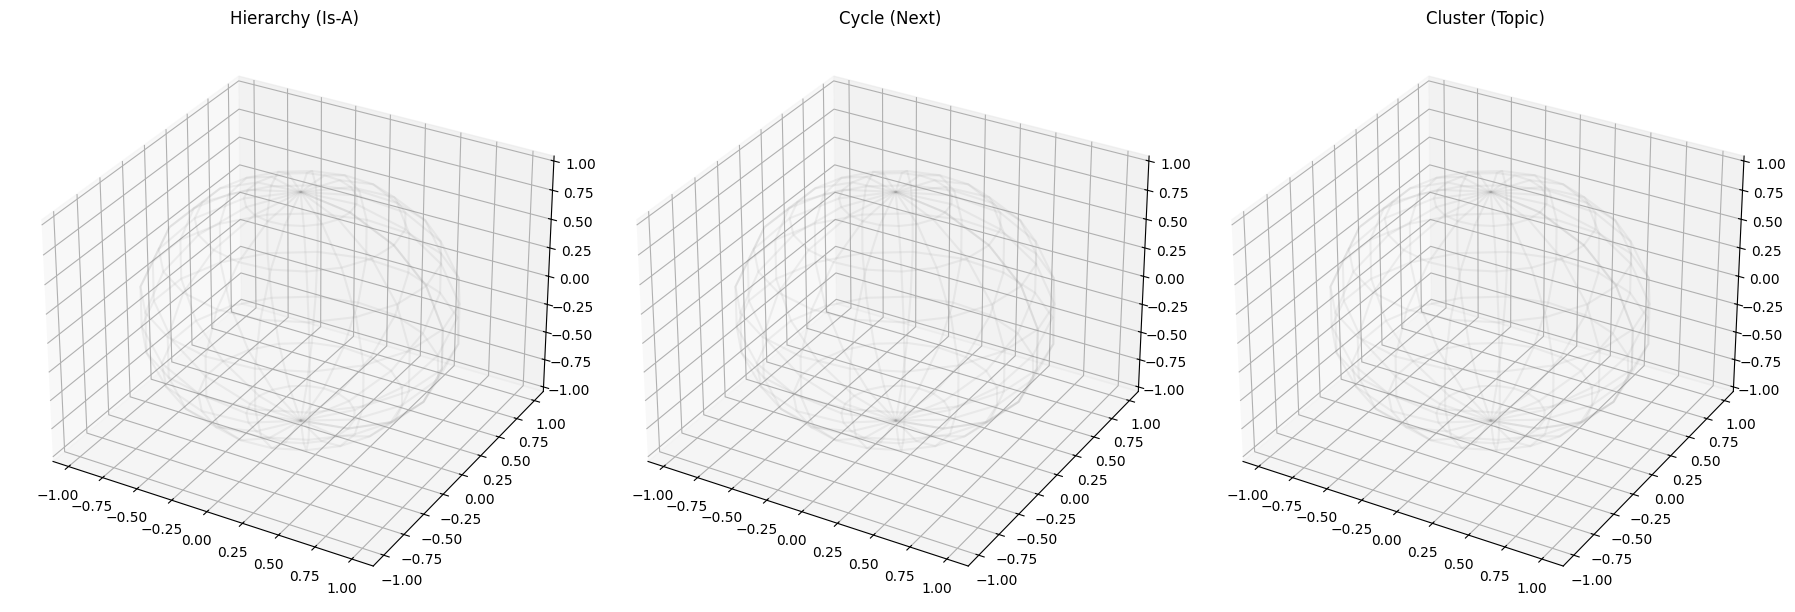

In [ ]:
from ham.embeddings import LearnableTokenMap
from ham.data.toy import ToyLanguage

def experiment_joint_learning():
    print("--- Experiment 5b: Joint Learning (Stabilized) ---")
    
    # 1. Load Data
    lang = ToyLanguage()
    src_batch, ctx_batch, tgt_batch = lang.get_batch()
    
    # 2. Setup Trainable Components
    manifold = Sphere(dim=2)
    # FIX 1: Increase epsilon to 0.05 (95% wind limit) for stability
    factory = RandersFactory(manifold, epsilon=0.05)
    
    key = jax.random.PRNGKey(42)
    k1, k2 = jax.random.split(key)
    
    # Brain & Map
    net = ContextNet(k1, vocab_size=3, context_dim=8, hidden_dim=64)
    token_map = LearnableTokenMap(k2, lang.vocab_size)
    
    # Solver: Fewer iters for training speed, but enough for gradient
    inner_solver = ProjectedGradientSolver(manifold, lr=0.05, max_iters=30)
    
    # 3. Optimization Setup
    model = (net, token_map)
    params, static = eqx.partition(model, eqx.is_array)
    
    # FIX 2: Slower Learning Rate
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(0.005) # Reduced from 0.02
    )
    opt_state = optimizer.init(params)
    
    @eqx.filter_jit
    def train_step(params, static, opt_state, src, ctx, tgt):
        def loss_fn(p):
            curr_net, curr_map = eqx.combine(p, static)
            s_coords = curr_map(src)
            t_coords = curr_map(tgt)
            
            # 1. Physics Loss (Attraction)
            def batch_loss(s, c, t):
                def metric_fn(x):
                    raw_L, raw_W = curr_net(x, c)
                    return factory.forward(x, raw_L, raw_W)
                
                init = jnp.linspace(s, t, 5)[1:-1]
                path = inner_solver.solve(lambda x: discrete_randers_energy(x, metric_fn), s, t, init)
                return discrete_randers_energy(path, metric_fn)

            attraction_loss = jnp.mean(vmap(batch_loss)(s_coords, ctx, t_coords))

            # 2. Separation Loss (Repulsion)
            dists = jnp.linalg.norm(s_coords[:, None, :] - s_coords[None, :, :], axis=-1)
            mask = jnp.eye(dists.shape[0])
            # Stronger repulsion kernel
            repulsion_energy = 1.0 / (dists + mask + 0.1) 
            repulsion_loss = jnp.mean(repulsion_energy * (1.0 - mask))
            
            # 3. Regularization
            reg = 1e-5 * sum(jnp.sum(w**2) for w in jax.tree_util.tree_leaves(p))
            
            # FIX 3: Higher Repulsion Weight (1.0) to prevent collapse
            return attraction_loss + 1.0 * repulsion_loss + reg, None

        (loss, _), grads = value_and_grad(loss_fn, has_aux=True)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        return optax.apply_updates(params, updates), opt_state, loss

    print("Training Joint Model...")
    
    # NaN Guard
    best_params = params
    best_loss = 100.0
    
    for i in range(1001):
        new_params, opt_state, loss = train_step(params, static, opt_state, src_batch, ctx_batch, tgt_batch)
        
        loss_val = float(loss)
        if np.isnan(loss_val):
            print(f"WARNING: NaN at epoch {i}. Stopping early.")
            params = best_params
            break
            
        if loss_val < best_loss:
            best_loss = loss_val
            best_params = new_params
            params = new_params
        else:
            params = new_params

        if i % 100 == 0: print(f"Epoch {i}: Energy {loss_val:.4f}")

    # 4. Visualization & Metrics
    final_net, final_map = eqx.combine(best_params, static)
    coords = np.array(final_map.all_coords)
    
    # Metric: Cycle Accuracy
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    correct_next = 0
    for i in range(len(days)):
        curr_w = days[i]
        next_w = days[(i+1)%7]
        curr_id = lang.word_to_id[curr_w]
        next_id = lang.word_to_id[next_w]
        
        curr_pos = coords[curr_id]
        raw_L, raw_W = final_net(jnp.array(curr_pos), 1) 
        m = factory.forward(jnp.array(curr_pos), raw_L, raw_W)
        flow = -m.beta 
        
        pred_pos = curr_pos + flow
        pred_pos /= np.linalg.norm(pred_pos)
        
        dists = np.linalg.norm(coords - pred_pos, axis=1)
        dists[curr_id] = 100.0 
        if np.argmin(dists) == next_id:
            correct_next += 1
            
    print(f"\nCycle Accuracy: {correct_next}/{len(days)} ({correct_next/len(days)*100:.1f}%)")

    fig = plt.figure(figsize=(18, 6))
    
    # Grid for wind visualization
    u_g, v_g = np.mgrid[0:2*np.pi:10j, 0.2:np.pi-0.2:5j]
    x_g = np.cos(u_g)*np.sin(v_g); y_g = np.sin(u_g)*np.sin(v_g); z_g = np.cos(v_g)
    grid_points = np.stack([x_g.flatten(), y_g.flatten(), z_g.flatten()], axis=1)
    
    def plot_context_with_grid(ax, c_id, title, color):
        ax.set_title(title)
        ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='gray', s=10, alpha=0.3)
        
        if c_id == 0: words = ["Entity", "Shape", "Triangle"]
        elif c_id == 1: words = days
        elif c_id == 2: words = ["Color", "Red", "Blue"]
        
        for w in words:
            if w in lang.word_to_id:
                idx = lang.word_to_id[w]
                ax.text(coords[idx,0], coords[idx,1], coords[idx,2], w, fontsize=8, weight='bold', color='black')
                ax.scatter(coords[idx,0], coords[idx,1], coords[idx,2], c=color, s=40)

        def get_wind(p):
            raw_L, raw_W = final_net(p, c_id)
            return -factory.forward(p, raw_L, raw_W).beta
        
        winds = vmap(get_wind)(jnp.array(grid_points))
        ax.quiver(grid_points[:,0], grid_points[:,1], grid_points[:,2], 
                  winds[:,0], winds[:,1], winds[:,2], length=0.15, color=color, alpha=0.6)
        
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = np.cos(u)*np.sin(v); y = np.sin(u)*np.sin(v); z = np.cos(v)
        ax.plot_wireframe(x, y, z, color="gray", alpha=0.1)

    ax1 = fig.add_subplot(131, projection='3d')
    plot_context_with_grid(ax1, 0, "Hierarchy (Is-A)", "magenta")
    
    ax2 = fig.add_subplot(132, projection='3d')
    plot_context_with_grid(ax2, 1, "Cycle (Next)", "cyan")
    
    ax3 = fig.add_subplot(133, projection='3d')
    plot_context_with_grid(ax3, 2, "Cluster (Topic)", "orange")
    
    plt.tight_layout()
    plt.show()

experiment_joint_learning()